# Data generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from astropy.io import fits
import math
from scipy import special
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def gryciuk(B, C, D, amp_scale, time_jd):
    # generate flare flux
    Z = (2*B+C**2*D**2) / (2*C)
    flux_jd = np.exp(D*(B-time_jd)+(C**2*D**2)/4.) * (special.erf(Z)-special.erf(Z-(time_jd/C)))
    # rescale to amp_scale
    flux_scale = np.max(flux_jd)
    flux_jd=amp_scale*flux_jd/flux_scale
    
    return flux_jd

def double_gaussian(sig_r, sig_f, amp_scale, time_jd):
    Frise = amp_scale * (np.exp(-(time_jd**2)/(2*sig_r)))
    F1 = amp_scale * (np.exp(-(time_jd**2)/(2*sig_f)))
    flux_jd = np.zeros(len(time_jd))
    neg_ind = time_jd < 0
    pos_ind = time_jd >= 0
    flux_jd[neg_ind] = Frise[neg_ind]
    flux_jd[pos_ind] = F1[pos_ind]

    return flux_jd


def exponential(t_start, t_f1, t_f2, time_jd):
    Frise = amp_scale * (1+1.941 *time_jd-0.175*time_jd**2-2.246*time_jd**3\
                       -1.125*time_jd**4)
    F1 = amp_scale*(0.948*np.exp(-0.965*time_jd))
    F2 = amp_scale*(0.322*np.exp(-0.290*time_jd))

    flux_jd = np.zeros(len(time_jd))
    left_ind = time_jd < 0
    mid_ind = (time_jd >= 0) & (time_jd < t_f1)
    right_ind = (time_jd >= t_f1) & (time_jd <= t_f2)
    flux_jd[left_ind] = Frise[left_ind]
    flux_jd[mid_ind] = F1[mid_ind]
    flux_jd[right_ind] = F2[right_ind]

    return flux_jd


def rescale_flare(flux_jd, time_jd, t_shift, scale_time, bw, dur):
    time_sc = (time_jd - time_jd[0]) * scale_time
    time_sh = time_sc + t_shift

    # interpolate onto right time binning
    time_bw = np.arange(min(time_sh), max(time_sh), bw)
    f_int = CubicSpline(time_sh, flux_jd)
    flux_bw = f_int(time_bw)

    # create array starting at t=0 and extending until t=dur
    npts = len(time_bw)
    time_bgd = np.arange(0, dur, bw)
    sub = int(time_bw[0]/bw)
    offset = np.random.uniform(low=0, high=100) # make offset a random positive number
    flux_bgd = np.full(len(time_bgd), offset)
    flux_bgd[sub:sub+npts] = flux_bgd[sub:sub+npts] + flux_bw
    
    return flux_bgd, time_bgd


def red_noise(sd_red, r, npts):
    w = np.random.normal(0, sd_red, npts)
    r_noise = np.zeros(npts)
    r_noise[0] = w[0]
    
    for i in range(1, npts):
        r_noise[i] = r*r_noise[i-1] + ((1-r**2)**0.5)*w[i]

    return r_noise
        
def is_qpp(iter_number):
     return iter_number % 2 == 0

In [ ]:
nrep = 10000 # number of repetitions in one group (flare trend + noise type)

FLARE_DUR = 20. # initial duration of flare
DATA_DUR = 300.  # final duration of series

QPP_SCALE_MIN = 0.05 # min QPP amplitude relative to the flare
QPP_SCALE_MAX = 0.5  # max QPP amplitude relative to the flare

P_SCALE_MIN = 5.0 # min number of QPP periods during the flare
P_SCALE_MAX = 15.0 # max number of QPP periods during the flare

T_E_SCALE_MIN = 1.0 # min QPP dissipation time relative to the QPP period
T_E_SCALE_MAX = 5.0 # max QPP dissipation time relative to the QPP period

SN_W_MIN = 1.0 # min QPP/white noise SN ratio
SN_W_MAX = 5.0 # max QPP/white noise SN ratio

SN_R_MIN = 1.0 # min QPP/red noise SN ratio
SN_R_MAX = 5.0 # max QPP/red noise SN ratio

NEW_LENGTH_MIN = 50 # mon length of flare after resampling

QPP_START_MIN = -0.05 # min QPP position relative to the flare peaks in flare length units
QPP_START_MAX = 0.1 # max QPP position relative to the flare peaks in flare length units

noise_types = ['white', 'red', 'both'] 
flare_types = ['gryc', 'd_gauss', 'exp']

DATASET_PATH = 'path_to_output_dataset'

dataset_info = {'N_REP': nrep, 'FLARE_DUR': FLARE_DUR, 'DATA_DUR': DATA_DUR, 'QPP_SCALE_MIN': QPP_SCALE_MIN,
               'QPP_SCALE_MAX': QPP_SCALE_MAX, 'P_SCALE_MIN': P_SCALE_MIN, 'P_SCALE_MAX': P_SCALE_MAX, 
                'T_E_SCALE_MIN': T_E_SCALE_MIN, 'T_E_SCALE_MAX': T_E_SCALE_MAX, 'SN_W_MIN': SN_W_MIN, 'SN_W_MAX': SN_W_MAX,
               'SN_R_MIN': SN_R_MIN, 'SN_R_MAX': SN_R_MAX, 'NEW_LENGTH_MIN': NEW_LENGTH_MIN,
               'QPP_START_MIN': QPP_START_MIN, 'QPP_START_MAX': QPP_START_MAX}

df = pd.DataFrame.from_dict([dataset_info])
df.to_csv(DATASET_PATH + 'dataset_info.csv')

In [ ]:
flare_id = 0
for flare_type in flare_types:
    data = []
    for noise_type in noise_types:

        qpp_scale_arr = np.random.uniform(low=QPP_SCALE_MIN, high=QPP_SCALE_MAX, size=nrep)
        P_scale_arr = np.random.randint(low=P_SCALE_MIN, high=P_SCALE_MAX, size=nrep)
        t_e_arr_scale=np.random.uniform(low=T_E_SCALE_MIN, high=T_E_SCALE_MAX, size=nrep)
        sn_w=np.random.uniform(low=SN_W_MIN, high=SN_W_MAX, size=nrep)
        sn_r=np.random.uniform(low=SN_R_MIN, high=SN_R_MAX, size=nrep)
        
        for i in range(nrep):
            
            bw_scale = 0.1 #generate initial at this and rescale later to ensure hits all breakpoints
            amp_scale = 10.0 + np.random.normal(0.0, 2.0)

            ###### flare generation ######
            if flare_type == 'gryc':
                B=np.random.uniform(low=0., high=5.)
                C=np.random.uniform(low=1., high=5.)
                D=np.random.uniform(low=0.5, high=1.0)

                time_jd = np.arange(0, FLARE_DUR + bw_scale, bw_scale)
                flux_jd = gryciuk(B, C, D, amp_scale, time_jd)

            if flare_type == 'd_gauss':
                sig_r = np.random.uniform(0.05 * FLARE_DUR, 0.15 * FLARE_DUR)
                sig_f = np.random.uniform(0.25 * FLARE_DUR, FLARE_DUR)
                t_start = -0.35 * FLARE_DUR
                t_f2 = 0.95 * FLARE_DUR 
                
                time_jd = np.arange(t_start, t_f2 + bw_scale, bw_scale)
                flux_jd = double_gaussian(sig_r, sig_f, amp_scale, time_jd)

            if flare_type == 'exp':
                t_start = -0.05 * FLARE_DUR  
                t_f1 = 0.08 * FLARE_DUR #point where breakpoint occurs
                t_f2 = 0.95 * FLARE_DUR #end of time series
                
                time_jd = np.arange(t_start, t_f2, bw_scale)
                flux_jd = exponential(t_start, t_f1, t_f2, time_jd)

            ###### flare rescaling and resampling ######
            bw = 1.0  #set desired bin width in final time series
            new_length = np.random.uniform(low=NEW_LENGTH_MIN, high=DATA_DUR)   #new length of flare
            t_shift = np.random.uniform(low=0., high=DATA_DUR-new_length) # lower limit ensures shifts far enough to get start of flare
            scale_time = new_length / (time_jd[-1] -  time_jd[0])
            flux_bgd, time_bgd = rescale_flare(flux_jd, time_jd,  t_shift, scale_time, bw, dur=DATA_DUR)

            ###### add qpp ######
            #qpp input parameters
            qpp_scale = qpp_scale_arr[i]
            a_qpp = qpp_scale * amp_scale # qpp amplitude
            B_qpp = 0
            P = new_length / P_scale_arr[i] #period
            t_e = t_e_arr_scale[i] * P #decay time
            phi=np.random.uniform(0, 2*np.pi) #phase

            #find the location of a peak
            i_max = np.argmax(flux_bgd)
            t_peak = time_bgd[i_max]

            t_qpp_start = math.floor(t_peak + new_length * np.random.uniform(low=QPP_START_MIN, high=QPP_START_MAX))
            if t_qpp_start < 0:
                t_qpp_start = 0
    
            #add decaying sine wave
            time_qpp = np.arange(0, math.floor(DATA_DUR-t_qpp_start), bw)
            n_qpp = len(time_qpp)
            f_qpp = a_qpp * np.exp(-(time_qpp-B_qpp)/t_e) * np.cos((2*np.pi*time_qpp)/P+phi)
            sub_qpp = int(t_qpp_start/bw)
            #add qpp on
            if is_qpp(i):
                flux_bgd[sub_qpp:sub_qpp+n_qpp] = flux_bgd[sub_qpp:sub_qpp+n_qpp] + f_qpp

            ###### add white noise ######
            #white noise parameters
            sn_white = sn_w[i]
            sn_scale = a_qpp / sn_white
            # generate white noise
            if noise_type in ['white', 'both']:
                w_noise = np.random.normal(0, sn_scale, len(flux_bgd))
                flux_jd_qpp_noise = flux_bgd + w_noise
            else:
                flux_jd_qpp_noise = flux_bgd

            ###### add red noise ######
            #red noise parameters
            r = 0.9 + np.random.uniform(low=-0.09, high=0.09)
            sn_red = sn_r[i]   
            sd_red = a_qpp / sn_red
            # generate red noise
            if noise_type in ['red', 'both']:
                r_noise = red_noise(sd_red, r, len(flux_bgd))
                flux_jd_qpp_noise = flux_jd_qpp_noise + r_noise

            # to output if no qpp was added
            if not is_qpp(i):
                a_qpp = 0

            ###### write files ######
            col1 = fits.Column(name='time', format='E', array=time_bgd)
            col2 = fits.Column(name='flux', format='E', array=flux_jd_qpp_noise)
            cols = fits.ColDefs([col1, col2])
            tbhdu = fits.BinTableHDU.from_columns(cols)
            tbhdu.writeto(DATASET_PATH + 'Sims_noise/flare' + str(flare_id) + '.fits', overwrite='true')
    
            col1 = fits.Column(name='time', format='E', array=time_bgd)
            col2 = fits.Column(name='model', format='E', array=flux_bgd)
            cols = fits.ColDefs([col1, col2])
            tbhdu = fits.BinTableHDU.from_columns(cols)
            tbhdu.writeto(DATASET_PATH + 'Sims_nonoise/flaremodel'+str(flare_id) + '.fits', overwrite='true')

            

            if flare_type == 'gryc':
                data.append({'id': flare_id, 't_peak': t_peak, 'amp_scale': amp_scale,
                            'B': B, 'C': C, 'D': D, 'new_length': new_length, 
                            'P': P, 'a_qpp': a_qpp, 'B_qpp': B_qpp, 't_e': t_e, 'phi': phi,
                            'sn_scale': sn_scale, 'r': r, 'sn_red': sn_red, 'n_type': noise_type})
 
            if flare_type == 'd_gauss':
                data.append({'id': flare_id, 't_peak': t_peak, 'amp_scale': amp_scale,
                            'sig_r': sig_r, 'sig_f': sig_f, 'new_length': new_length, 
                            'P': P, 'a_qpp': a_qpp, 'B_qpp': B_qpp, 't_e': t_e, 'phi': phi,
                            'sn_scale': sn_scale, 'r': r, 'sn_red': sn_red, 'n_type': noise_type})

            if flare_type == 'exp':
                data.append({'id': flare_id, 't_peak': t_peak, 'amp_scale': amp_scale,
                             'new_length': new_length,
                            'P': P, 'a_qpp': a_qpp, 'B_qpp': B_qpp, 't_e': t_e, 'phi': phi,
                            'sn_scale': sn_scale, 'r': r, 'sn_red': sn_red, 'n_type': noise_type})
            
            print('flare_id', flare_id, 'P', P, 't_e', t_e, 'a_qpp', a_qpp)

            # increase id by 1
            flare_id += 1
            

    if flare_type == 'gryc':
        output_path = DATASET_PATH + 'file_info_Gryciuk.csv'
    if flare_type == 'd_gauss':
        output_path = DATASET_PATH + 'file_info_Double_Gauss.csv'
    if flare_type == 'exp':
        output_path = DATASET_PATH + 'file_info_Exp.csv'

    data = pd.DataFrame.from_dict(data)
    data.to_csv(output_path)

## Create labels

Here, we create labels using file_info_***.csv files

In [ ]:
base_path = 'path_to_dataset_folder'
# base_path = DATASET_PATH
labels = []

### Gryciuk

In [67]:
path = 'file_info_Gryciuk.csv'

In [68]:
data = pd.read_csv(base_path + path)
data

,Unnamed: 0,id,t_peak,amp_scale,B,C,D,new_length,P,a_qpp,B_qpp,t_e,phi,sn_scale,r,sn_red,n_type
0,0,0,73.0,10.026913,2.361014,2.712917,0.518795,201.564102,22.396011,3.946400,0,94.443710,4.273164,2.471846,0.828546,1.191326,white
1,1,1,172.0,10.539345,3.750953,3.936410,0.606761,108.098721,9.827156,0.000000,0,29.289895,5.955910,2.937301,0.842253,2.700602,white
2,2,2,59.0,8.202807,1.110177,3.586058,0.577571,228.910980,17.608537,0.579645,0,39.442080,1.903597,0.152166,0.836478,3.071430,white
3,3,3,142.0,9.280843,1.792196,4.627863,0.940807,114.341724,10.394702,0.000000,0,45.599723,3.229862,1.401024,0.924180,1.394563,white
4,4,4,29.0,14.050951,1.974292,2.118670,0.790914,143.188570,23.864762,2.092574,0,57.401232,5.157365,0.832163,0.849302,1.959963,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,29995,100.0,12.987958,4.179765,4.189303,0.513522,248.176548,22.561504,0.000000,0,80.555601,6.238945,2.461342,0.896425,3.373132,both
29996,29996,29996,32.0,10.056262,0.311435,4.232552,0.945205,296.127115,49.354519,2.863772,0,162.654031,3.135318,0.647438,0.886779,1.631389,both
29997,29997,29997,144.0,7.684185,1.616250,3.258450,0.721319,161.421926,17.935770,0.000000,0,64.924185,5.661890,0.482631,0.913941,1.863784,both
29998,29998,29998,48.0,8.654380,2.270543,4.176419,0.537127,233.985675,21.271425,3.751756,0,88.663000,6.133497,1.654629,0.968832,2.038607,both


In [69]:
data['qpp'] = 0
data.loc[data.a_qpp > 0, 'qpp'] = 1
data['type'] = ''
data.loc[(data.qpp > 0) & (data.n_type == 'white'), 'type'] = 'gr_w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'white'), 'type'] = 'gr_w_0'
data.loc[(data.qpp > 0) & (data.n_type == 'red'), 'type'] = 'gr_r_1'
data.loc[(data.qpp == 0) & (data.n_type == 'red'), 'type'] = 'gr_r_0'
data.loc[(data.qpp > 0) & (data.n_type == 'both'), 'type'] = 'gr_r&w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'both'), 'type'] = 'gr_r&w_0'
labels.append(data[['id', 'qpp', 'type']])

### Double guassian

In [70]:
path = 'file_info_Double_Gauss.csv'

In [71]:
data = pd.read_csv(base_path + path)
data

,Unnamed: 0,id,t_peak,amp_scale,sig_r,sig_f,new_length,P,a_qpp,B_qpp,t_e,phi,sn_scale,r,sn_red,n_type
0,0,30000,78.0,7.798110,1.689096,16.223326,236.370795,21.488254,1.126449,0,39.545823,4.285993,0.246099,0.845885,4.573456,white
1,1,30001,108.0,11.049547,1.778130,5.661871,57.486242,6.387360,0.000000,0,18.707300,4.402442,2.864775,0.862977,1.505356,white
2,2,30002,177.0,8.236732,2.807174,17.698357,52.509950,7.501421,3.684669,0,17.116573,4.784504,0.957378,0.868891,2.491032,white
3,3,30003,99.0,10.658287,2.947049,17.976819,128.811811,14.312423,0.000000,0,65.853204,5.528777,1.441489,0.823652,2.611362,white
4,4,30004,102.0,10.310732,2.954289,6.982965,257.399836,18.385703,2.117495,0,70.730107,4.853787,0.531835,0.831300,3.971786,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,59995,134.0,8.690815,1.663719,5.549688,191.140376,13.652884,0.000000,0,30.903817,3.329498,0.348322,0.941215,2.750440,both
29996,29996,59996,59.0,12.890798,2.806864,15.151451,171.034718,14.252893,6.444223,0,48.558256,4.918687,1.450915,0.885985,2.981140,both
29997,29997,59997,174.0,12.107648,1.433660,11.115116,140.619960,17.577495,0.000000,0,39.917782,3.482711,1.964597,0.828139,3.553231,both
29998,29998,59998,107.0,11.170548,1.824800,8.391708,252.029447,19.386881,1.271253,0,33.161666,4.559750,0.491989,0.875564,3.700556,both


In [72]:
data['qpp'] = 0
data.loc[data.a_qpp > 0, 'qpp'] = 1
data['type'] = ''
data.loc[(data.qpp > 0) & (data.n_type == 'white'), 'type'] = 'dg_w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'white'), 'type'] = 'dg_w_0'
data.loc[(data.qpp > 0) & (data.n_type == 'red'), 'type'] = 'dg_r_1'
data.loc[(data.qpp == 0) & (data.n_type == 'red'), 'type'] = 'dg_r_0'
data.loc[(data.qpp > 0) & (data.n_type == 'both'), 'type'] = 'dg_r&w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'both'), 'type'] = 'dg_r&w_0'
labels.append(data[['id', 'qpp', 'type']])

### Exponential

In [73]:
path = 'file_info_Exp.csv'

In [74]:
data = pd.read_csv(base_path + path)
data

,Unnamed: 0,id,t_peak,amp_scale,new_length,P,a_qpp,B_qpp,t_e,phi,sn_scale,r,sn_red,n_type
0,0,60000,97.0,10.823481,209.813499,41.962700,4.977377,0,59.762419,1.478722,2.431829,0.952144,4.527543,white
1,1,60001,93.0,9.432930,122.061419,11.096493,0.000000,0,18.397532,6.201359,3.195056,0.977538,2.041977,white
2,2,60002,29.0,10.361122,205.692974,41.138595,1.170607,0,125.026426,4.366124,0.710180,0.878697,2.990401,white
3,3,60003,166.0,12.324436,137.644171,13.764417,0.000000,0,47.659339,3.911543,0.378692,0.966275,4.602596,white
4,4,60004,83.0,9.997949,210.758016,42.151603,2.233273,0,156.881976,0.800778,1.075892,0.861869,4.671324,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,89995,131.0,6.024288,138.931230,9.923659,0.000000,0,13.121969,4.004239,1.318166,0.954836,2.144025,both
29996,29996,89996,117.0,10.714917,189.251555,21.027951,1.431997,0,78.961338,0.735402,0.293608,0.827029,4.043143,both
29997,29997,89997,69.0,13.344036,86.877227,7.239769,0.000000,0,13.768303,0.822370,1.447583,0.820172,2.742381,both
29998,29998,89998,65.0,11.097909,237.669697,39.611616,3.834865,0,113.088619,2.267491,1.977240,0.952879,2.917288,both


In [75]:
data['qpp'] = 0
data.loc[data.a_qpp > 0, 'qpp'] = 1
data['type'] = ''
data.loc[(data.qpp > 0) & (data.n_type == 'white'), 'type'] = 'exp_w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'white'), 'type'] = 'exp_w_0'
data.loc[(data.qpp > 0) & (data.n_type == 'red'), 'type'] = 'exp_r_1'
data.loc[(data.qpp == 0) & (data.n_type == 'red'), 'type'] = 'exp_r_0'
data.loc[(data.qpp > 0) & (data.n_type == 'both'), 'type'] = 'exp_r&w_1'
data.loc[(data.qpp == 0) & (data.n_type == 'both'), 'type'] = 'exp_r&w_0'
labels.append(data[['id', 'qpp', 'type']])

### Concat labels

In [76]:
labels = pd.concat(labels)
labels

,id,qpp,type
0,0,1,gr_w_1
1,1,0,gr_w_0
2,2,1,gr_w_1
3,3,0,gr_w_0
4,4,1,gr_w_1
...,...,...,...
29995,89995,0,exp_r&w_0
29996,89996,1,exp_r&w_1
29997,89997,0,exp_r&w_0
29998,89998,1,exp_r&w_1


In [77]:
# Look at labels' distrubution
labels['type'].value_counts()

type
gr_w_1       5000
gr_w_0       5000
exp_r&w_1    5000
exp_r_0      5000
exp_r_1      5000
exp_w_0      5000
exp_w_1      5000
dg_r&w_0     5000
dg_r&w_1     5000
dg_r_0       5000
dg_r_1       5000
dg_w_0       5000
dg_w_1       5000
gr_r&w_0     5000
gr_r&w_1     5000
gr_r_0       5000
gr_r_1       5000
exp_r&w_0    5000
Name: count, dtype: int64

In [78]:
labels.to_csv(base_path + 'labels_new.csv', index=False)

In [79]:
labels = pd.read_csv(base_path + 'labels_new.csv')
labels

,id,qpp,type
0,0,1,gr_w_1
1,1,0,gr_w_0
2,2,1,gr_w_1
3,3,0,gr_w_0
4,4,1,gr_w_1
...,...,...,...
89995,89995,0,exp_r&w_0
89996,89996,1,exp_r&w_1
89997,89997,0,exp_r&w_0
89998,89998,1,exp_r&w_1


### Train/validation/test split

Then, we separate out data into train/test/validation subsets

In [80]:
labels.to_csv(base_path + 'labels_new.csv', index=False)
labels_train, labels_val_test = train_test_split(labels, test_size=0.2, random_state=42)
labels_val, labels_test = train_test_split(labels_val_test, test_size=0.5, random_state=42)

72000


<Axes: ylabel='type'>

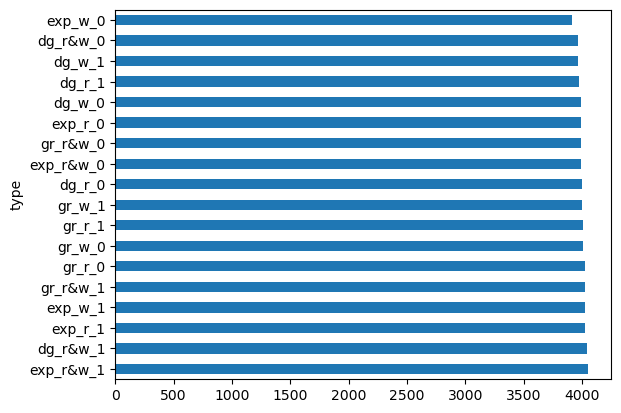

In [81]:
# Types' distribution in train
print(len(labels_train))
labels_train.type.value_counts().plot.barh()

9000


<Axes: ylabel='type'>

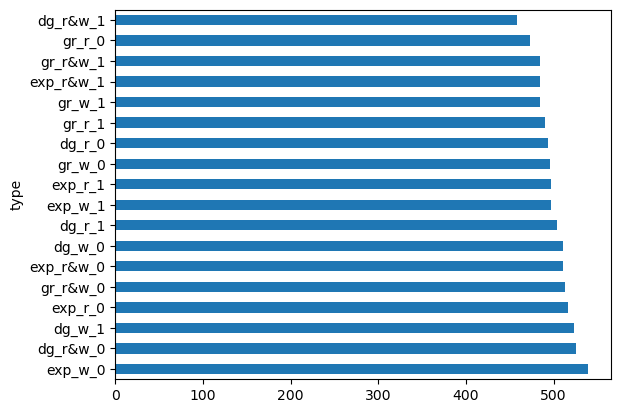

In [82]:
# Types' distribution in validation
print(len(labels_val))
labels_val.type.value_counts().plot.barh()

9000


<Axes: ylabel='type'>

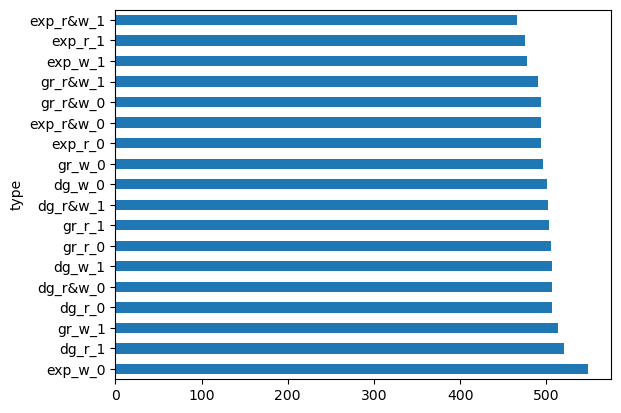

In [83]:
# Types' distribution in test
print(len(labels_test))
labels_test.type.value_counts().plot.barh()

In [84]:
# Save labels to .csv
labels_train.drop(columns=['type']).to_csv(base_path + 'labels_train.csv', index=False)
labels_val.drop(columns=['type']).to_csv(base_path + 'labels_val.csv', index=False)
labels_test.drop(columns=['type']).to_csv(base_path + 'labels_test.csv', index=False)
